# Using OSMnx to work with street networks

OSMnx is a Python library that lets you download spatial geometries and construct, project, and visualize street networks from OpenStreetMap's API.  It makes heavy use of the NetworkX library for network analysis.

https://www.openstreetmap.org  

OSMnx documentation: https://osmnx.readthedocs.io/en/stable/index.html  
OSMnx examples: https://github.com/gboeing/osmnx-examples/tree/master/notebooks

NetworkX documentation: https://networkx.github.io/documentation/stable/

OSMnx and NetworkX are the best place to start for these tasks. But it case the performance is too slow for your use cases, there's another set of libraries that's optimized for fast distance and accessibility calculations over long distances:

Pandana: http://udst.github.io/pandana/  
UrbanAccess: https://udst.github.io/urbanaccess/index.html (for GTFS transit data)  
OSMNet: https://udst.github.io/osmnet/index.html

In [1]:
%%capture
!pip install osmnx==0.12

In [2]:
# cell 1

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import networkx as nx
import osmnx
print(osmnx.__version__)
osmnx.config(log_file=True, log_console=True, use_cache=True)

0.12


## 1. Download place boundaries from OpenStreetMap

OSMnx lets you download spatial "place boundary" geometries from OpenStreetMap, save them, project them, and plot them. For a more in-depth demonstration, see [this notebook](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/02-example-osm-to-shapefile.ipynb).

OSMnx [gdf_from_place()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.gdf_from_place)

In [3]:
# cell 2

city = osmnx.gdf_from_place('Manhattan, New York, New York, USA')
type(city)

geopandas.geodataframe.GeoDataFrame

In [4]:
# cell 3

city.head()

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"MULTIPOLYGON (((-74.04722 40.69086, -74.04722 ...","Manhattan, New York County, New York, United S...",40.880449,40.683941,-73.906159,-74.047222


### Projecting and plotting

You can plot this using any of the standard tools, but OSMNx also has some helper functions to create common map types:

OSMnx [project_gdf()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_gdf) -- uses the optimal local UTM projection by default  
OSMnx [plot_shape()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.plot.plot_shape)

In [5]:
# cell 4

osmnx.project_gdf(city).head()

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"MULTIPOLYGON (((580503.876 4504877.304, 580504...","Manhattan, New York County, New York, United S...",40.880449,40.683941,-73.906159,-74.047222


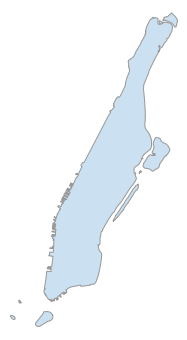

In [6]:
# cell 5

fig, ax = osmnx.plot_shape(osmnx.project_gdf(city))
fig.show()

### Multiple places at once

OSMnx [gdf_from_places()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.gdf_from_places)

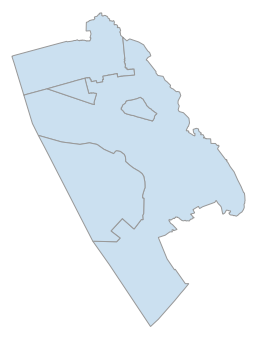

In [7]:
# cell 6

place_names = ['Berkeley, California, USA', 
               'Oakland, California, USA',
               'Piedmont, California, USA',
               'Emeryville, California, USA',
               'Alameda, Alameda County, CA, USA']

east_bay = osmnx.gdf_from_places(place_names)

fig, ax = osmnx.plot_shape(osmnx.project_gdf(east_bay))
fig.show()

### Exercise

Try downloading some other place outlines!

## 2. Download and process street networks from OpenStreetMap

OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, or shapefiles for later use. The street networks are directed and preserve one-way directionality. For a more in-depth demonstration of creating street networks, see [this notebook](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/03-example-osm-place-network.ipynb).

Note that a **graph** is the math/computer science term for the data structure you probably think of as a "network": a set of vertices/nodes/points that are connected by edges/links/lines. More [here](https://en.wikipedia.org/wiki/Graph_(abstract_data_type)). This can be confusing because data visualizations are often called "graphs" as well; it seems like this originally referred only to network diagrams but has now expanded to include more things. Consider calling your data visualizations "charts" instead!

You can download a street network by providing OSMnx any of the following:
  - a bounding box
  - a lat-lon point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries

You can also specify several different network types:
  - 'drive' - get drivable public streets (but not service roads)
  - 'drive_service' - get drivable streets, including service roads
  - 'walk' - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - 'bike' - get all streets and paths that cyclists can use
  - 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - 'all_private' - download all OSM streets and paths, including private-access ones
  
See OSMnx [graph_from_...()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.graph_from_address) function APIs.

 ### Streets within a bounding box
 This constructs the network from all the OSM "nodes" (a.k.a. intersections or vertices) and "ways" (a.k.a. streets, edges, links, etc.) within the bounding box.

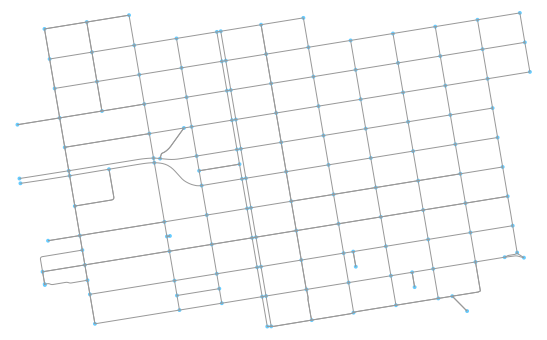

In [8]:
# cell 7

# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G1 = osmnx.graph_from_bbox(north, south, east, west, network_type='drive')
G1_projected = osmnx.project_graph(G1)

fig, ax = osmnx.plot_graph(G1_projected)
fig.show()

In [9]:
# cell 8

type(G1)

networkx.classes.multidigraph.MultiDiGraph

### Streets within a place name

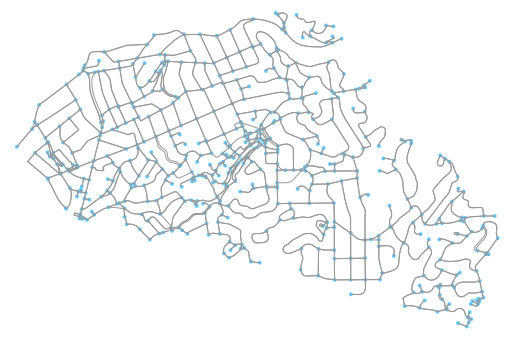

In [10]:
# cell 9

# create the street network within the city of Piedmont's borders
G2 = osmnx.graph_from_place('Piedmont, California, USA')
G2_projected = osmnx.project_graph(G2)

fig, ax = osmnx.plot_graph(G2_projected)
fig.show()

### Streets within a distance radius

This can be either a straight-line distance (implemented as a bounding box) or a network distance. 

If it's a *driving* network, the network distances will respect one-way streets, but if it's a *walking* network, two-way travel is allowed everywhere.

OSMnx [graph_from_point()](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.core.graph_from_point)

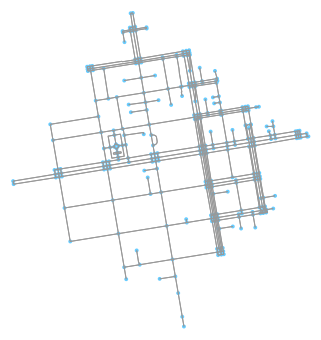

In [11]:
# cell 10

# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create network only of nodes within 500m walking along the network from point
G3 = osmnx.graph_from_point(location_point, distance=500, distance_type='network', network_type='walk')
G3 = osmnx.project_graph(G3)

fig, ax = osmnx.plot_graph(G3)
fig.show()

### Streets within a polygon

This example loads the [Mission District](http://www.zillow.com/howto/api/neighborhood-boundaries.htm)'s polygon from a shapefile, then downloads the network within its bounding box, then prunes all nodes that lie outside the place's boundary polygon.

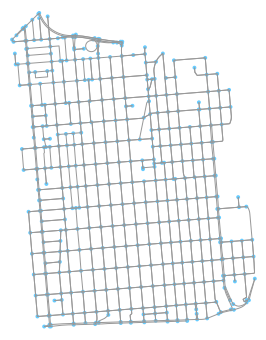

In [12]:
# cell 11

calif = gpd.read_file('zip://ZillowNeighborhoods-CA.zip')
mission_district = calif[(calif['CITY']=='San Francisco') & (calif['NAME']=='Mission')]
polygon = mission_district['geometry'].iloc[0]

G4 = osmnx.graph_from_polygon(polygon, network_type='drive')
G4_projected = osmnx.project_graph(G4)

fig, ax = osmnx.plot_graph(G4_projected)
fig.show()

### Exercise

Try getting a specific type of network for some place in the world -- (in the interest of time, don't get too big a city or other geography).  Try for walk vs drive vs some other type.

## 3. Simplifying street network topology

Simplification is normally done by OSMnx automatically under the hood, but we can break it out to see how it works. OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge. For a more in-depth demonstration of topological simplification with OSMnx, see [this notebook](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/04-example-simplify-network.ipynb).

In [13]:
# cell 12

# create a network around some (lat, lon) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = osmnx.graph_from_point(location_point, network_type='drive_service', distance=500, simplify=False)

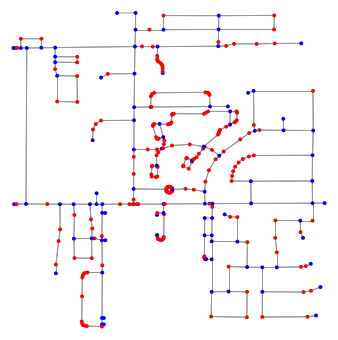

In [14]:
# cell 13

# turn off strict mode and see what nodes we'd remove, in red
nc = ['b' if osmnx.is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_color=nc, node_zorder=3)
fig.show()

The red and blue dots above are OSM nodes. We'll remove the nodes in red as they're not real network nodes.

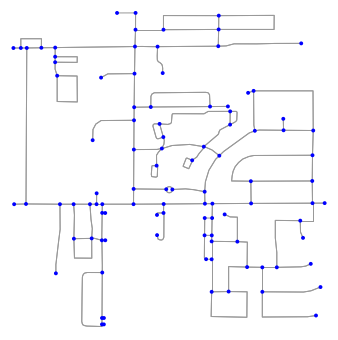

In [15]:
# cell 14

# simplify the network
G = osmnx.simplify_graph(G)
fig, ax = osmnx.plot_graph(G, node_color='b', node_zorder=3)
fig.show()

### Begin looking at network characteristics

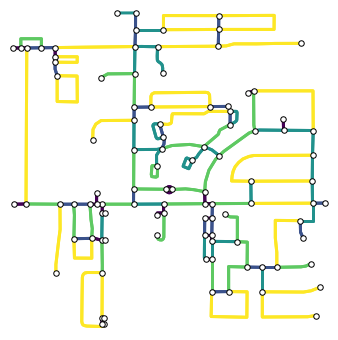

In [16]:
# cell 15

# show the simplified network with edges colored by edge length
ec = osmnx.get_edge_colors_by_attr(G, attr='length')
fig, ax = osmnx.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, 
                              node_zorder=3, edge_color=ec, edge_linewidth=3)
fig.show()

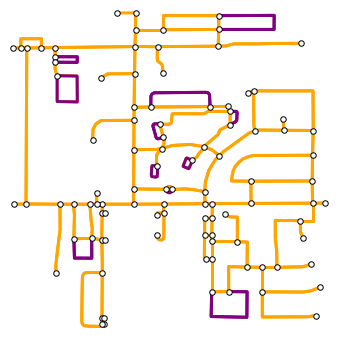

In [17]:
# cell 16

# highlight all parallel edges in purple
ec = ['orange' if key == 0 else 'purple' for u, v, key in G.edges(keys=True)]
fig, ax = osmnx.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, 
                              node_zorder=3, edge_color=ec, edge_linewidth=3)
fig.show()

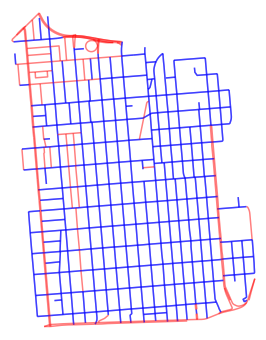

In [18]:
# cell 17

# highlight all the one-way edges in the mission district network from earlier
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G4_projected.edges(keys=True, data=True)]
fig, ax = osmnx.plot_graph(G4_projected, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)
fig.show()

## 4. Converting networks and saving them to disk

Remember that the street networks are *not* GeoDataFrames -- they contain information about both **nodes** (points) and **edges** (lines). When you save them to geospatial formats like a Shapefile or GeoJSON, you'll need two separate files.

For more examples of saving and loading networks to/from disk, see [this notebook](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/05-example-save-load-networks-shapes.ipynb).

API documentation for [saving and loading](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.save_load)

In [19]:
# cell 18

# save street network in shapefile format, automatically generating two files
osmnx.save_graph_shapefile(G4, filename='network-shape')

### Conversion from network to GeoDataFrames

In [20]:
# cell 19

# convert street network to geodataframes
gdf_nodes, gdf_edges = osmnx.graph_to_gdfs(G4)

In [21]:
# cell 20

gdf_nodes.head(3)

,y,x,osmid,highway,ref,geometry
65345537,37.753770,-122.419705,65345537,NaN,NaN,POINT (-122.41970 37.75377)
65307650,37.768627,-122.424430,65307650,NaN,NaN,POINT (-122.42443 37.76863)
65345543,37.748973,-122.419257,65345543,NaN,NaN,POINT (-122.41926 37.74897)


In [22]:
# cell 21

gdf_edges.head(3)

,u,v,key,osmid,oneway,highway,name,length,geometry,maxspeed,lanes,access,ref,bridge
0,65345537,65345534,0,8919626,True,residential,Bartlett Street,179.006,"LINESTRING (-122.41970 37.75377, -122.41976 37...",NaN,NaN,NaN,NaN,NaN
1,65345537,65319641,0,286672835,False,residential,23rd Street,97.608,"LINESTRING (-122.41970 37.75377, -122.41982 37...",NaN,NaN,NaN,NaN,NaN
2,65345537,65359046,0,286672835,False,residential,23rd Street,96.138,"LINESTRING (-122.41970 37.75377, -122.41961 37...",NaN,NaN,NaN,NaN,NaN


In [23]:
# cell 22

# now, you can save the GeoDataFrames directly
# https://geopandas.org/io.html#writing-spatial-data

gdf_nodes.to_file('nodes.geojson', driver='GeoJSON')

### Exercise

Take one of the street networks we've loaded, convert its edges to a GeoDataFrame, and generate a list of all the street names.

Hint: the data types are a little messy, but something like this should work for the last step.

`gdf_edges['name'].astype('str').unique()`

## 5. Network statististics (topological and metric)

Network analysis is not all about shortest path calculations.  Network science is an entire field of analysis that exlores networks as mathematical / topological 'graphs'.  Also transportation planners use network structure information to inform analysis of travel behavior.  The 3Ds work by Cervero and Kockleman have evolved into 7Ds (or more) by researchers and practitioners trying to understand what urban design characteristics are associated with more walking and less driving.

Below we explore functionality that OSMnx offers, with considerable help from Networkx under the hood, to provide these kinds of calculations. 

For more depth, see [this notebook](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/06-example-osmnx-networkx.ipynb).

In [24]:
# cell 23

# get the network for Piedmont and calculate its basic stats
osmnx.basic_stats(osmnx.graph_from_place('Piedmont, California, USA'))

{'n': 557,
 'm': 1493,
 'k_avg': 5.360861759425494,
 'intersection_count': 487,
 'streets_per_node_avg': 2.872531418312388,
 'streets_per_node_counts': {0: 0, 1: 70, 2: 2, 3: 418, 4: 64, 5: 2, 6: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.12567324955116696,
  2: 0.003590664272890485,
  3: 0.7504488330341114,
  4: 0.11490125673249552,
  5: 0.003590664272890485,
  6: 0.0017953321364452424},
 'edge_length_total': 135159.69799999995,
 'edge_length_avg': 90.52893369055589,
 'street_length_total': 70002.295,
 'street_length_avg': 90.32554193548387,
 'street_segments_count': 775,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.08732802479241,
 'self_loop_proportion': 0.0053583389149363695,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

## 6. Shortest path routing

Let the origin node be the node nearest the location and let the destination node just be the last node in the network. Then find the shortest path between origin and destination. The edges can be weighted in various different ways, but distance or travel time are the most common approaches.

In [25]:
# cell 24

# define a lat-long point, create network around point, define origin/destination nodes
location_point = (37.791427, -122.410018)
G = osmnx.graph_from_point(location_point, distance=500, distance_type='network', network_type='walk')
origin_node = osmnx.get_nearest_node(G, location_point)
destination_node = list(G.nodes())[-1]

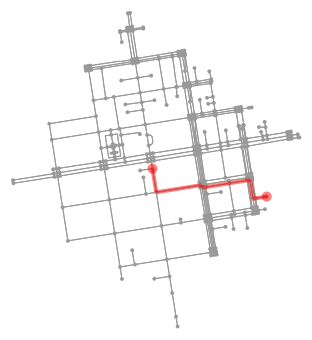

In [26]:
# cell 25

# find the route between these nodes then plot it
route = nx.shortest_path(G, origin_node, destination_node)  # this is a NetworkX function

fig, ax = osmnx.plot_graph_route(G, route)
fig.show()

### Routing from one lat-lon to another

In [27]:
# cell 26

# define origin/desination points then get the nodes nearest to each
origin_point = (37.792896, -122.412325)
destination_point = (37.790495, -122.408353)

origin_node = osmnx.get_nearest_node(G, origin_point)
destination_node = osmnx.get_nearest_node(G, destination_point)
origin_node, destination_node

(850803362, 65290756)

In [28]:
# cell 27

# find the shortest path between origin and destination nodes
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

'[850803362, 633686735, 633686762, 633686748, 633686743, 850803353, 6250503226, 7231544187, 7231525077, 7231544186, 7231066384, 7231084794, 7231084796, 7231066371, 6319217969, 7231066376, 7231068083, 6319217970, 7231068081, 6319217966, 7231012156, 7231068078, 7231068074, 65290756]'

In [29]:
# cell 28

type(route)

list

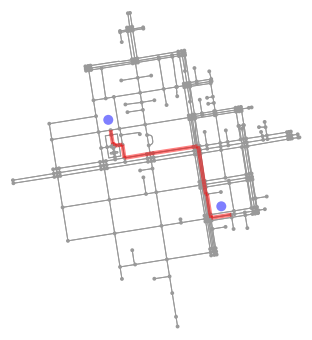

In [30]:
# cell 29

# plot the route showing origin/destination lat-long points in blue
fig, ax = osmnx.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)
fig.show()

### Distance of shortest paths

API reference: NetworkX [shortest_path_length()](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path_length.html#networkx.algorithms.shortest_paths.generic.shortest_path_length)

In [31]:
# cell 30

nx.shortest_path_length(G, source=origin_node, target=destination_node, weight='length')

637.763

### Exercise

Pick an area of a city and download the OSM street graph for it. Choose two locations and find the shortest path between them!

Tip: One way to get lat-lon coordinates for arbitrary places is by right-clicking (or control-clicking) on a spot in Google Maps and choosing "What's here".

## 7. Plot a city's street network as an interactive web map

OSMnx has its own helper functions for plotting interactive web maps, incase you'd like to use them.

API reference: OSMnx [Plot module](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.plot)

In [32]:
# cell 31

from IPython.display import IFrame

In [33]:
# cell 32

# download the street network for Piedmont, CA
G = osmnx.graph_from_place('Piedmont, California, USA', network_type='drive')

In [34]:
# cell 33

# plot the street network with folium
graph_map = osmnx.plot_graph_folium(G, popup_attribute='name', edge_width=2)

In [35]:
# cell 34

# save as html file then display map as an iframe
filepath = 'data/graph.html'
graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

You can zoom into the street network above or click any edge to get more info.

### Add a route

In [36]:
# cell 35

# use networkx to calculate the shortest path between two nodes
origin_node = list(G.nodes())[0]
destination_node = list(G.nodes())[-1]
route = nx.shortest_path(G, origin_node, destination_node)

In [37]:
# cell 36

# plot the route with folium on top of the previously created graph_map
route_graph_map = osmnx.plot_route_folium(G, route, route_map=graph_map, popup_attribute='length')

In [38]:
# cell 37

# save as html file then display map as an iframe
filepath = 'data/route_graph.html'
route_graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

## Final exercise

Experiment with the methods you find most interesting in this notebook, on a place of your own choosing. For large areas, you may need to install Ananconda locally on your computer to get around DataHub's memory and processing limits.